C:\Users\pc\AppData\Local\Temp\ipykernel_7512\1837123265.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series.fillna(method="ffill")  # forward fill for non-trading days if any


Train points: 2218, Test points: 413


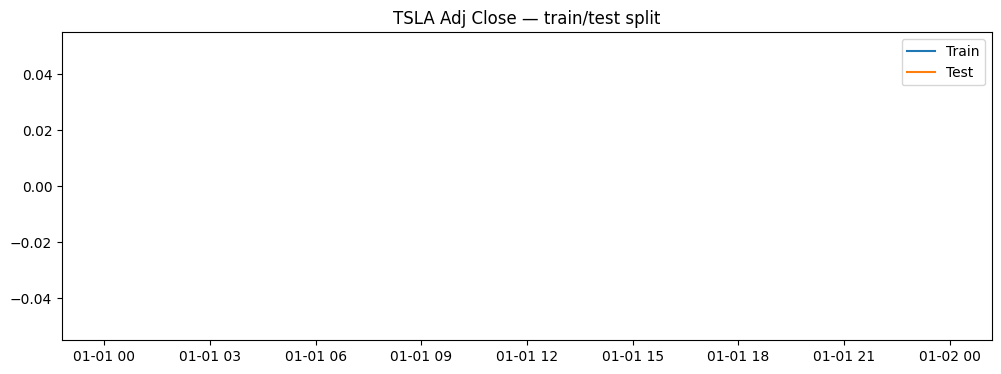

In [ ]:
# --- cell: prepare series & split ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

data=pd.read_csv(r'C:\Users\pc\Time-Series-Forecasting-for-Portfolio-Management-Optimization\data\financial_data_clean.csv')

# assume `data` is the processed DataFrame saved earlier
tsla = data[data["Ticker"] == "TSLA"].copy()
tsla.sort_values("Date", inplace=True)
tsla.set_index("Date", inplace=True)

# Use Adj_Close as target
series = tsla["Adj_Close"].asfreq('B')  # business-day frequency; missing days will be NaN
series = series.fillna(method="ffill")  # forward fill for non-trading days if any

# Chronological split: train up to end of 2023, test 2024-01-01 onward (adjust if you prefer)
train = series[: "2015-12-31"]
test  = series["2024-01-01":]

print(f"Train points: {len(train)}, Test points: {len(test)}")

plt.figure(figsize=(12,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.legend()
plt.title("TSLA Adj Close — train/test split")
plt.show()


In [4]:
# --- cell: ARIMA auto_arima ---
import pmdarima as pm

# auto_arima will pick p,d,q (and seasonal if desired). set seasonal=False or True depending on data.
arima_model = pm.auto_arima(train,
                            start_p=0, start_q=0,
                            max_p=5, max_q=5,
                            seasonal=False,        # set True and m=5/252/etc if you expect seasonality
                            stepwise=True,
                            suppress_warnings=True,
                            error_action='ignore',
                            trace=True,
                            information_criterion='aic')

print(arima_model.summary())

# Forecast for length of test
n_periods = len(test)
arima_forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True)
arima_index = test.index[:n_periods]
arima_pred = pd.Series(arima_forecast, index=arima_index)
arima_ci = pd.DataFrame(conf_int, index=arima_index, columns=['lower','upper'])


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
# --- cell: ARIMA evaluation ---
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

arima_mae, arima_rmse, arima_mape = evaluate(test[:n_periods], arima_pred)
print(f"ARIMA MAE: {arima_mae:.4f}, RMSE: {arima_rmse:.4f}, MAPE: {arima_mape:.2f}%")

# Plot actual vs ARIMA forecast
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train', alpha=0.6)
plt.plot(test.index, test, label='Actual', color='black')
plt.plot(arima_pred.index, arima_pred, label='ARIMA Forecast', color='orange')
plt.fill_between(arima_ci.index, arima_ci['lower'], arima_ci['upper'], color='orange', alpha=0.2)
plt.legend()
plt.title("ARIMA Forecast vs Actuals")
plt.show()


In [ ]:
# --- cell: LSTM prep ---
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras

# Use only the train window to fit scaler to avoid leakage
scaler = MinMaxScaler()
train_values = train.values.reshape(-1,1)
scaler.fit(train_values)

series_scaled = scaler.transform(series.values.reshape(-1,1)).flatten()
series_scaled = pd.Series(series_scaled, index=series.index)

# create supervised windows
def create_windows(series_values, window_size):
    X, y = [], []
    for i in range(len(series_values) - window_size):
        X.append(series_values[i:i+window_size])
        y.append(series_values[i+window_size])
    return np.array(X), np.array(y)

WINDOW = 60  # 60 business days ~3 months; tune this
# training window: use scaled values for train only
train_scaled = series_scaled[: len(train)]
X_train, y_train = create_windows(train_scaled.values, WINDOW)

# For test forecasting, we'll use a rolling prediction approach (walk-forward)
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)


In [ ]:
# --- cell: LSTM model ---
tf.random.set_seed(42)

model = keras.Sequential([
    keras.layers.Input(shape=(WINDOW, 1)),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(32),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# reshape X_train to (samples, window, 1)
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
history = model.fit(X_train_reshaped, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.1,
                    verbose=2)


In [ ]:
# --- cell: LSTM forecasting (walk-forward) ---
def walk_forward_forecast(model, full_series_scaled, train_len, window_size, steps):
    preds = []
    # start with last window from the training portion
    last_window = full_series_scaled[train_len - window_size : train_len].tolist()
    for _ in range(steps):
        x = np.array(last_window[-window_size:]).reshape(1, window_size, 1)
        yhat = model.predict(x, verbose=0)[0,0]
        preds.append(yhat)
        last_window.append(yhat)
    return np.array(preds)

# full scaled series values (index aligned)
full_scaled_vals = series_scaled.values
lstm_preds_scaled = walk_forward_forecast(model, full_scaled_vals, len(train), WINDOW, n_periods)

# inverse-scale predictions
lstm_preds = scaler.inverse_transform(lstm_preds_scaled.reshape(-1,1)).flatten()
lstm_pred_series = pd.Series(lstm_preds, index=test.index[:n_periods])
